<a href="https://colab.research.google.com/github/bayu-wilson/MoveNet_project/blob/main/DanceSpinTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dance Spin Tracker

Bayu Wilson

### Motivation
The objective of this computer vision project is to track the number of times a single dancer spins/turns in each direction (over right of left shoulder). This project could be expanded on and applied to live fitness and movement applications. For example, a professional dancer may want to keep track of movements like spinning to quantify their training routine. This can help to ensure a dancer sufficiently practices to improve but does not over-train, risking injury. Tracking number of spins in both directions is important as well because it can help prevent muscular imbalances developed during biased training. It can also monitor creativity biases during improvised dancing or performances (i.e. a choreographer spinning in one direction significantly more than the other). Lastly, it could be used in an ethnomusicological context. On page 55, [table 1.1](https://drive.google.com/file/d/13SPHCf94HYKWoEIaKNVrBEtmyad39JaZ/view?usp=drive_link) in the book "Spinning Mambo into Salsa" by Juliet McMains, one of the major aesthetic differences between Palladium-Era Mambo of the 1950's and the Modern New York-Style Salsa/Mambo today is the number of spins/turns done by the dancers. Palladium-Era dancers typically would do few simple turns and idiosyncratic solo moves while modern dancers today incorporate multiple, complex turns. Computer vision is a tool worth considering in the context of quantitative dance ethnography.


### Methodology and Tools
In this project I am taking advantage of a pre-trained pose detection model made by Google Research, called **[MoveNet](https://t.co/QpfnVL0YYI?amp=1)**. Copied from [TF Hub](https://www.tensorflow.org/hub/tutorials/movenet), it is an "*ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.*". I found this model on TensorFlow hub, which is a useful library containing ample resusable machine learning components like this. This helps to build ML applications without starting from scratch.

#### How MoveNet works
The prediction scheme loosely follows [CenterNet](https://arxiv.org/abs/1904.07850) which models an object as a single point, the center point of its bounding box. This approach is faster than bounding box based detectors. I recall learning about bounding box based detectors in the Deep Learning Specialization I took from Andrew Ng. In these types of algorithms, an object detecting method is first used to tightly encompass the object this may use sliding windows or a complex arrangement of overlapping bounding anchor boxes similar to the YOLO algorithm. Note: Anchor boxes are used to help grid cells detect multiple overlapping objects, Non-max suppression is a way to make sure algorithms detects each object only once, and IoU is intersection over unions which is a measure of overlap.

The CenterNet/MoveNet is simpler and more efficient alternative. It ends up being a standard keypoint estimation problem. Keypoints are just notable features/landmarks in an image/video such as body/face parts. The images are fed into a fully convolutional network (FCN) (this just means CNN's with no fully connected dense layers at the end). So the output could be a spatial map instead of a single vector of class scores. In this case, the FCN is used to generate a heatmap where the object centers are the peaks. Then the main idea is that this enables a rich feature map to be output where keypoints are able to be identified easily.

The model was trained using the COCO standar benchmark dataset as well as an internal Google dataset called Active. It was important to augment the COCO dataset with more challenging poses and motion blur which is common in fitness and dance applications.

One of the most significant speed ups was to use lower resolution inputs to the models. To make up for the loss in resolution, a more intelligent cropping method is used which allowed the model to devote more of its attention and resources to the main subject, and not the background.


### Defining a turn
Though this project can be easily generalized to other genres of dance, I will set the contraints based off of salsa dancing. I will define salsa music to have a BPM ranging from 140 and 250 (2.3 and 4.2 beats per second respectively). A spin ber a beat in a 250 BPM song is difficult so we can define that as the fastest spin. In order to classify the spin, we would require at least 4 snapshots during movement. Therefore 4.2 spins per second * 4 snapshots = **16.4 FPS as the minimum frame rate**. Luckily my iPhone has FPS of 30 which is plenty.  

We also define a minimum time in which a spin must be completed. In salsa the slowest type of turn takes around 3 counts/beats. In a 140 BPM song, that is 3 beats / 2.3 BPS = 1.3 seconds. It turns out it is easier to deal with number of frames so 1.3 seconds * 30 fps = 39 frames. **A turn must occur within 1.3 seconds of 39 frames**

### Quantifying a turn
In order to quantify a turn, I first define 4 orientations: facing front, right, back, and left. To simplify the definition of a full turn, the starting and ending point of the turn must be towards the camera (facing front). A right turn would mean an orientation pattern of FRONT->RIGHT->BACK->LEFT->FRONT and a left turn would mean FRONT->LEFT->BACK->RIGHT->FRONT.

I classify orientation simply using only 3 keypoints: the left shoulder, the right shoulder, and the nose. If nose is further to the left, then the person is left facing and vice versa to the right. And then the shoulder orientation can be easily used to define forward vs backward facing.



```
def get_orientation(x_ls,x_rs,x_n):
    """
    x_ls: x-coordinate of left shoulder
    x_rs: x-coordinate of right shoulder
    x_n: x-coordinate of nose
    """
    if (x_rs<x_n)&(x_n<x_ls):
        return "front"
    elif (x_rs<x_n)&(x_ls<x_n):
        return "left"
    elif (x_ls<x_n)&(x_n<x_rs):
        return "back"
    elif (x_n<x_ls)&(x_n<x_rs):
        return "right"
    else:
        return "Error: something went wrong."
```




### Limitations of this work as well as future work that could be done
- This has only been tested on a single dancer. In principle, it should also work with multiple dancers.
- One could try transfer learning and remove the last few layers of the fully-convolutional network and then retrain it with video data of partner dancing. Relative keypoints in the context of partner dancing could be interesting and novel.
- It's possible that an orientation pattern like FRONT->RIGHT->BACK->RIGHT->BACK->LEFT->FRONT could be done within the time constraint. My spin tracking method may not count this.
- This hasn't been tested on noisy data yet.
- There are definitely improvements that could be made to make this code more efficient.


## Loading modules

In [253]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [254]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

## Defining relevant functions

In [257]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))


#### The following are used in the image sequencing portion of this project

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores


In [258]:
def get_orientation(x_ls,x_rs,x_n):
    """
    x_ls: x-coordinate of left shoulder
    x_rs: x-coordinate of right shoulder
    x_n: x-coordinate of nose
    """
    if (x_rs<x_n)&(x_n<x_ls):
        return "front"
    elif (x_rs<x_n)&(x_ls<x_n):
        return "left"
    elif (x_ls<x_n)&(x_n<x_rs):
        return "back"
    elif (x_n<x_ls)&(x_n<x_rs):
        return "right"
    else:
        return "Error: something went wrong."

## Obtaining model from tensor-flow hub and defining the MoveNet model

In [259]:
model_name = "movenet_lightning" # @param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

In [260]:
if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


## Mounting local Google Drive

In [263]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
working_dir = "drive/MyDrive/MoveNetProject/"
saving_calib = working_dir + "output_images/calibration.png"

Mounted at /content/drive/


## Calibrating orientation classification

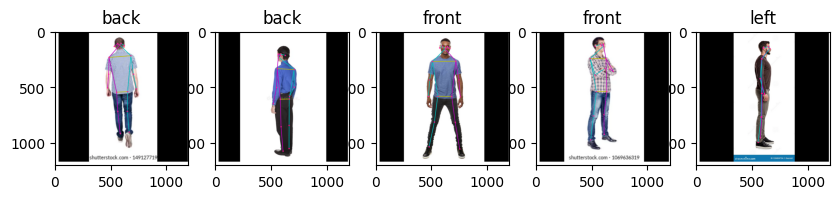

In [264]:
pose_calibration_images = ["backwards.png","back-diag.png","front.png","front-diag.png","side.png"]

fig,ax = plt.subplots(1,len(pose_calibration_images),squeeze=False,figsize=(10,2))
for i in range(len(pose_calibration_images)):
    # Loading each image as a tensor and preparing them to be input into the model
    im_path = working_dir+"pose_calibration/"+str(pose_calibration_images[i])
    image = tf.io.read_file(im_path)
    image = tf.image.decode_png(image)
    input_image = tf.expand_dims(image, axis=0) #adding a dimension in axis=0
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
    ax[0,i].imshow(output_overlay)

    #extracting nose and shoulder keypoint coordinates
    x_n = keypoints_with_scores[0,0][:,1][0] #0,5,6
    x_ls = keypoints_with_scores[0,0][:,1][5]
    x_rs = keypoints_with_scores[0,0][:,1][6]
    orientation = get_orientation(x_ls,x_rs,x_n)

    ax[0,i].set_title(orientation)
plt.savefig(saving_calib,dpi=250)

Looks good!

### Image sequencing

Now that we confirmed that the orientation classifier is working, let's try to apply it to a video (image sequence). You can see a spin demo [here](https://drive.google.com/file/d/1tk2NUIP_wmiNHCWMGbi5JKeNgKGTGd6K/view?usp=drive_link) where I do a right fast single turn, a left rhythmic double turn, and a right double spin on one foot. **In total that is 3 right turns and 2 left turns.**

In [267]:
image_path = working_dir+"pose_calibration/SpinVideoDemo.gif" #TensorShape([300, 1920, 1080, 3])
# image_path = working_dir+"pose_calibration/dance.gif" #TensorShape([42, 338, 600, 3])
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

In [268]:
# Load the input image sequence.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
dancer_orientations = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  x_n = keypoints_with_scores[0,0][:,1][0] #0,5,6
  x_ls = keypoints_with_scores[0,0][:,1][5]
  x_rs = keypoints_with_scores[0,0][:,1][6]
  orientation = get_orientation(x_ls,x_rs,x_n)
  dancer_orientations.append(orientation)
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
# to_gif(output, duration=100)

In [269]:
unique_categories = ["front","right","back","left"] #np.unique(dancer_orientations)
category_to_index = {orientation: index for index, orientation in enumerate(unique_categories)}
numerical_labels = np.array([category_to_index[orientation] for orientation in dancer_orientations])

In [276]:
save_snapshots = False     #it can be slow to save the snapshots every time so consider turning this off during debugging
tracker = 0               #if tracker=4 then RHRD spin. If tracker=-4 then RHRU spin.
time_chunk_threshold = 39 #turns only count if they took less than a 1.3 seconds. So 39 frames (assuming fps=30)
time_checker = 0          #iterate this parameter to ensure that the turns are faster than the threshold
total_RHRU_spins = 0      #RHRU means right-hand rule up (left turns)
total_RHRD_spins = 0      #RHRD means right-hand rule down (right turns)
N_labels = len(numerical_labels) #number of labeled snapshots

assert numerical_labels[0]==0 #start facing the front. For simplicity, I assert this.
for i in range(1,N_labels):
  time_flag = time_checker>=time_chunk_threshold #time_flag is True if the turn is too slow.

  if (numerical_labels[i]==0): #keep time_checker equal to zero until a turn starts happening.
    time_checker=0
  else: #iterate time_checker everytime not facing the front
    time_checker+=1

  if time_flag: # if time-checker is greater than threshold then skip rest of loop
    if numerical_labels[i]==0: #if additionally facing the front, reset tracker. This ensures that you don't count the slow turns.
      tracker=0                #when it goes back to the top of the loop, time-checker will also reset to 0.
    continue

  # the difference between consecutive numerical orientation labels. It can be (1,-3) for RHRD or (-1,3) for RHRU turns.
  difference = int(numerical_labels[i]-numerical_labels[i-1])
  if (difference==0): #do nothing. keep this line or else the "else" line won't work correctly
    continue
  elif difference in [1,-3]: #This means RHRD quarter turn
    tracker+=1
  else: #this means RHRU quarter turn.
    tracker-=1

  if tracker==4: #4 quarter turns means 1 RHRD turn
    tracker=0
    total_RHRD_spins +=1
  elif tracker==-4:  #-4 quarter turns means 1 RHRU turn
    tracker=0
    total_RHRU_spins +=1



  if save_snapshots:
    fig, ax = plt.subplots(1,figsize=(4,6))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(output[i])
    ax.text(0.08, 0.95, f"RS:{total_RHRD_spins:02}\nLS:{total_RHRU_spins:02}", transform=ax.transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(working_dir+f"output_movie/snapshots/movie_snapshot{i}.png")
    plt.close(fig)

Again we expect 3 right turns and 2 left turns so this looks like it is working correctly.

In [282]:
print(f"Number of right turns: {total_RHRD_spins}\nNumber of left turns: {total_RHRU_spins}")

Number of right turns: 3
Number of left turns: 2


### Finally let's combine these frames together to make a video with our Dance Spin Tracker.

In [283]:
image_folder =working_dir+f"output_movie/snapshots/"
image_paths = []
for i in range(1,len(numerical_labels)):
  snapshot_path = working_dir+f"output_movie/snapshots/movie_snapshot{i}.png"
  image_paths.append(snapshot_path)

In [284]:
video_file = working_dir+f"output_movie/movie.mp4"

# Frame rate (frames per second)
fps = 30

# Read the first image to get dimensions
first_image = cv2.imread(image_paths[0])
height, width, layers = first_image.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'XVID', 'MJPG', 'X264', etc.
video = cv2.VideoWriter(video_file, fourcc, fps, (width, height))

# Write each frame to the video
for image in image_paths:
    #img_path = os.path.join(image_folder, image)
    frame = cv2.imread(image)
    video.write(frame)

# Release the VideoWriter
video.release()

print(f"Video saved as {video_file}")

Video saved as drive/MyDrive/MoveNetProject/output_movie/movie.mp4


You can watch the movie [here](https://drive.google.com/file/d/17KZUPwvBw1nVT6s_R2EDPVJx6qUFJbyH/view?usp=sharing)!

### code graveyard

Ignore this.

In [ ]:
# # save_snapshots = False
# # tracker = 0 #if tracker=4 then RHRD spin. If tracker=-4 then RHRU spin.
# # time_chunk_boundary = 30 #turns only count if they took less than a second. So 30 frames (assuming fps=30)
# # time_checker = 0
# # total_RHRU_spins = 0
# # total_RHRD_spins = 0
# # # test_labels = np.array([0,0,3,2,1,0,3,2,1,0,1,2,3,0])
# # assert numerical_labels[0]==0 #start facing the front
# # for i in range(1,len(numerical_labels)):
# #   if (numerical_labels[i]==0):
# #     time_checker=0
# #   else:
# #     time_checker+=1

# #   time_flag = time_checker<time_chunk_boundary

# #   if time_flag:
# #     difference = int(numerical_labels[i]-numerical_labels[i-1])
# #     if (difference==0):
# #       pass
# #     elif difference in [1,-3]:
# #       tracker+=1
# #     else:
# #       tracker-=1

# #     if tracker==4:
# #       tracker=0
# #       total_RHRD_spins +=1
# #     elif tracker==-4:
# #       tracker=0
# #       total_RHRU_spins +=1

# #   else:
# #     time_checker = 0
# #   # difference = int(numerical_labels[i]-numerical_labels[i-1])
# #   # if (difference==0):
# #   #   pass
# #   # elif difference in [1,-3]:
# #   #   tracker+=1
# #   # else:
# #   #   tracker-=1
# #   # print(difference,tracker)




# #   if save_snapshots:
# #     fig, ax = plt.subplots(1,figsize=(4,6))
# #     ax.set_xticklabels([])
# #     ax.set_yticklabels([])
# #     ax.set_xticks([])
# #     ax.set_yticks([])
# #     ax.imshow(output[i])
# #     ax.text(0.08, 0.95, f"RS:{total_RHRD_spins:02}\nLS:{total_RHRU_spins:02}", transform=ax.transAxes,
# #             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
# #     plt.savefig(working_dir+f"output_movie/snapshots/movie_snapshot{i}.png")
# #     plt.close(fig)

# # images = []
# # for i in range(1,len(numerical_labels)):
# #   snapshot_path = working_dir+f"output_movie/snapshots/movie_snapshot{i}.png"
# #   images.append(imageio.imread(snapshot_path))

# # imageio.mimsave(working_dir+f"output_movie/movie.gif", images,fps=10000)
# qwer = np.array([0,1,2,3,0])
# asdf = np.array([0,3,2,1,0])
# np.diff(qwer), np.diff(asdf)
# X = [None,None,None,None,None]
# for i in range(20):
#   X.append(i)
#   X.pop(0)
# X
# array[np.concatenate(([True], array[1:] != array[:-1]))]
# # array = np.array(dancer_orientations)
# unique_categories = ["front","right","back","left"]#np.unique(dancer_orientations)
# category_to_index = {orientation: index for index, orientation in enumerate(unique_categories)}
# numerical_labels = np.array([category_to_index[orientation] for orientation in dancer_orientations])

# # CCW_counts = 0
# # CW_counts = 0
# # counter = 0
# # for i in range(len(numerical_labels)-1):
# #   if numerical_labels[i] == numerical_labels[i+1]: #orientation unchanged
# #     pass
# #   elif numerical_labels[i] > numerical_labels[i+1]:

# #   else:

# # is_consecutive = np.concatenate(([True], array[1:] != array[:-1]))
# # array[is_consecutive]
# # # for i in range(len(dancer_orientations)):
# # #   orientation
# # np.diff(dancer_orientations)
# is_consecutive = np.concatenate(([True], numerical_labels[1:] != numerical_labels[:-1]))
# numerical_labels[is_consecutive]
# rotation if 0,1,2,3 happens
# # to_gif(output,fps=5)
# # imageio.mimwrite('./animation.gif', output[:50],duration = 10)# duration=duration)

# # numerical_labels = np.array([0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,
# #                              0,1,2,3,0,0,1,2,3,0,0,0,3,2,1,0,0,0,0])
# # numerical_labels = np.array([0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,1,2,3,0])
# # numerical_labels = np.array([0, 3, 2, 1,0])
# # numerical_labels = np.array([0,3,2,1,0,0,0,0])
# # len(numerical_labels)
# # numerical_labels